In [1]:
# General-purpose Python library imports
import re
import warnings
import zipfile
from collections import Counter
from itertools import chain

# Data handling library imports
import pandas as pd
import numpy as np

# Finance data library import
import yfinance as yf

# Data visualization library imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

# Natural Language Processing (NLP) library imports
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download necessary NLP datasets
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Aishwarya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aishwarya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aishwarya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
try:
    # Trying to read as an xlsx file
    amz = pd.read_excel('Amazon.xlsx')
except ValueError:
    # If it fails, trying to read as an xls file
    amz = pd.read_excel('Amazon.xlsx', engine='xlrd')

In [3]:
amz.head()

,Date,Tweet content,Tweet language,Is a RT,Company Name
0,2016-06-15 09:45:00,Try the discovery engine &amp; social network ...,en,False,Amazon
1,2016-06-15 09:35:00,"Andreas Halvorsen Buys Facebook, Amazon, Maste...",en,False,Amazon
2,2016-06-15 09:26:00,RT @MarketsRecap: These 3 Stocks Will Surprise...,en,True,Amazon
3,2016-06-15 09:21:00,"OnePlus 3 launched at a price of Rs 27,999; av...",en,False,Amazon
4,2016-06-15 08:53:00,Ocado shares plummet as #Amazon Fresh launches...,en,False,Amazon


In [4]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Sentiment Score without any processing

In [5]:
# Applying sentiment analysis to the 'Tweet content' column
amz['Sentiment Score'] = amz['Tweet content'].apply(lambda tweet: sia.polarity_scores(tweet)['compound'])

# Convert the 'Date' column to datetime and truncate time for daily analysis
amz['Date'] = pd.to_datetime(amz['Date']).dt.date

# Group by the new 'Date' column and calculate the daily average of the Sentiment Score
daily_avg = amz.groupby('Date')['Sentiment Score'].mean()

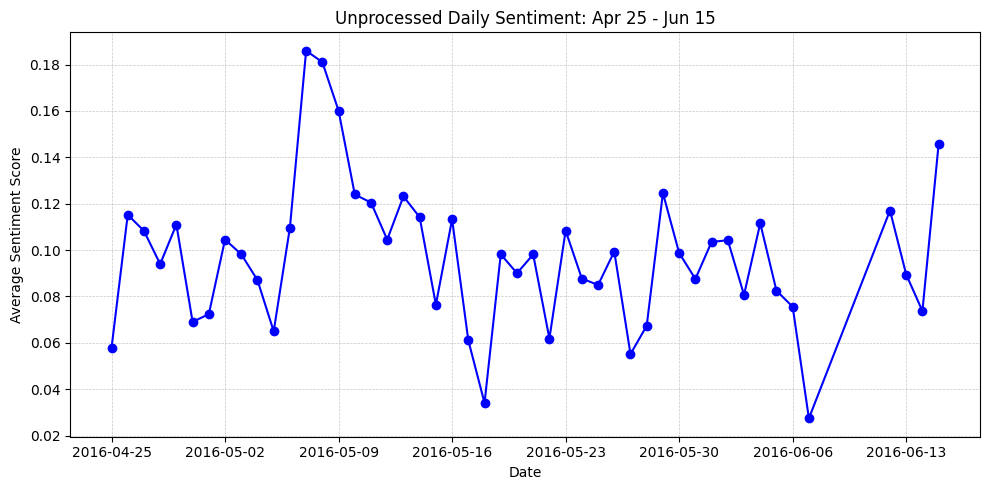

In [6]:
#  Making 'daily_avg' index is of type datetime.date
daily_avg.index = pd.to_datetime(daily_avg.index).date

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(daily_avg.index, daily_avg.values, 'bo-')
plt.title('Unprocessed Daily Sentiment: Apr 25 - Jun 15')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')

# Define the date format for the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set x-axis to have major ticks every 7 days and limit the display to the range
date_range = pd.date_range(start='2016-04-25', end='2016-06-15', freq='D')
plt.gca().set_xticks([date for date in date_range if date.weekday() == 0])  # Every Monday

# Enable grid for better readability of the plot
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Use tight layout to automatically adjust subplot params
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
amz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38192 entries, 0 to 38191
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             38192 non-null  object 
 1   Tweet content    38192 non-null  object 
 2   Tweet language   38192 non-null  object 
 3   Is a RT          38192 non-null  bool   
 4   Company Name     38192 non-null  object 
 5   Sentiment Score  38192 non-null  float64
dtypes: bool(1), float64(1), object(4)
memory usage: 1.5+ MB


In [8]:
amz.astype({'Tweet content': 'string', 'Tweet language': 'string', 'Company Name': 'string', 'Date': 'datetime64[ns]'}).dtypes

Date               datetime64[ns]
Tweet content      string[python]
Tweet language     string[python]
Is a RT                      bool
Company Name       string[python]
Sentiment Score           float64
dtype: object

In [9]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [10]:
def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove user mentions
    tweet = re.sub(r'@[^\s]+', '', tweet)

    # Remove special characters, punctuation, and numbers
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

    # Remove retweet indicators
    tweet = re.sub(r'rt\d+', '', tweet)

    # Convert data to lowercase
    tweet = tweet.lower()

    # Removing stopwords
    clean_words = [word for word in tweet.split() if word.lower() not in stopwords.words('english')]

    return ' '.join(clean_words)

In [11]:
# Word tokenization
def word_tokenization(tweet):
    # Tokenization
    words = nltk.word_tokenize(tweet)
    return words

In [12]:
amz['Tweet content preprocessed'] = amz['Tweet content'].apply(remove_emojis)
amz['Tweet content preprocessed'] = amz['Tweet content preprocessed'].apply(preprocess_tweet)
amz['Tweet content preprocessed'] = amz['Tweet content preprocessed'].apply(word_tokenization)

In [13]:
amz.astype({'Tweet content': 'string', 'Tweet content preprocessed': 'string', 'Tweet language': 'string', 'Company Name': 'string', 'Date': 'datetime64[ns]'}).dtypes

Date                          datetime64[ns]
Tweet content                 string[python]
Tweet language                string[python]
Is a RT                                 bool
Company Name                  string[python]
Sentiment Score                      float64
Tweet content preprocessed    string[python]
dtype: object

# Sentiment Score after preprocessing

In [14]:
# Converted from list to string before analysis
amz['Sentiment Score 2'] = amz['Tweet content preprocessed'].apply(lambda tweet: sia.polarity_scores(' '.join(tweet))['compound'])

# Group by the new 'Date' column and calculate the daily average of the Sentiment Score
daily_avg = amz.groupby('Date')['Sentiment Score 2'].mean()

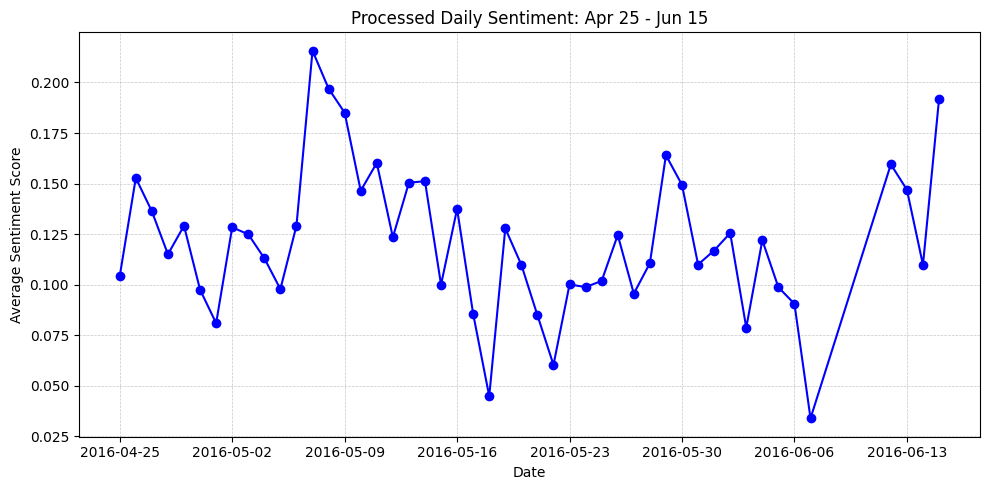

In [15]:
# Plotting with specific formatting and date handling as in the first code snippet
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(daily_avg.index).date, daily_avg.values, 'bo-')  # Match marker and line style
plt.title('Processed Daily Sentiment: Apr 25 - Jun 15')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')

# # Define the date format for the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set x-axis to have major ticks every 7 days and limit the display to the range
date_range = pd.date_range(start='2016-04-25', end='2016-06-15', freq='D')
plt.gca().set_xticks([date for date in date_range if date.weekday() == 0])  # Every Monday

# Enable grid for better readability of the plot
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Use tight layout to automatically adjust subplot params
plt.tight_layout()

# Show the plot
plt.show()


# Categorising the words for display

In [16]:
# Function to calculate sentiment score
def sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Sentiment categorization dictionary
sentiment_words = {'positive': {}, 'negative': {}, 'neutral': {}}

In [17]:
# Converting a multi-level (nested) list into a single-level list, combining all elements into one sequence.
all_tokens = list(chain.from_iterable(amz['Tweet content preprocessed']))

# Count Word Frequencies
word_counts = Counter(all_tokens)

# Sort and Select Top 50
top_50_words = word_counts.most_common(50)

# Print the top 50 words with their frequencies
print(top_50_words)

[('amzn', 38713), ('amazon', 8527), ('rt', 7551), ('fb', 6965), ('aapl', 6908), ('nflx', 4410), ('read', 3853), ('goog', 3777), ('spy', 3586), ('googl', 3112), ('tsla', 3027), ('msft', 2703), ('qqq', 2627), ('stocks', 2463), ('twtr', 2120), ('new', 2008), ('stock', 1834), ('inc', 1756), ('buy', 1544), ('amp', 1489), ('earnings', 1445), ('spx', 1401), ('market', 1160), ('video', 1134), ('via', 1123), ('trading', 1122), ('sell', 1076), ('day', 1060), ('amazons', 1027), ('iwm', 1007), ('today', 989), ('prime', 968), ('baba', 960), ('see', 949), ('wmt', 948), ('apple', 931), ('like', 878), ('cloud', 854), ('tech', 852), ('bezos', 828), ('pt', 827), ('top', 823), ('retail', 817), ('may', 816), ('dia', 786), ('lnkd', 780), ('short', 746), ('trade', 739), ('ibm', 738), ('week', 737)]


In [18]:
amz.astype({'Tweet content': 'string', 'Tweet content preprocessed': 'string', 'Tweet language': 'string', 'Company Name': 'string', 'Date': 'datetime64[ns]'}).dtypes

Date                          datetime64[ns]
Tweet content                 string[python]
Tweet language                string[python]
Is a RT                                 bool
Company Name                  string[python]
Sentiment Score                      float64
Tweet content preprocessed    string[python]
Sentiment Score 2                    float64
dtype: object

In [19]:
for tweet in all_tokens:
    # Convert tweet to string if it's not
    tweet_text = ' '.join(tweet) if isinstance(tweet, list) else tweet
    # Calculate sentiment score for each tweet
    score = sentiment_score(tweet_text)
    if score > 0.1:
        sentiment_words['positive'][tweet_text] = score
    elif score <= 0 and score > -0.1:
        sentiment_words['negative'][tweet_text] = score
    elif -0.1 <= score <= 0.1:
        sentiment_words['neutral'][tweet_text] = score

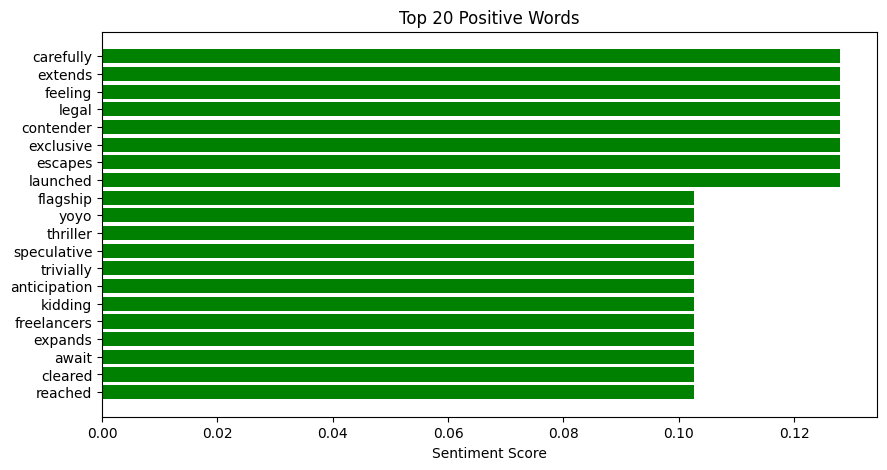

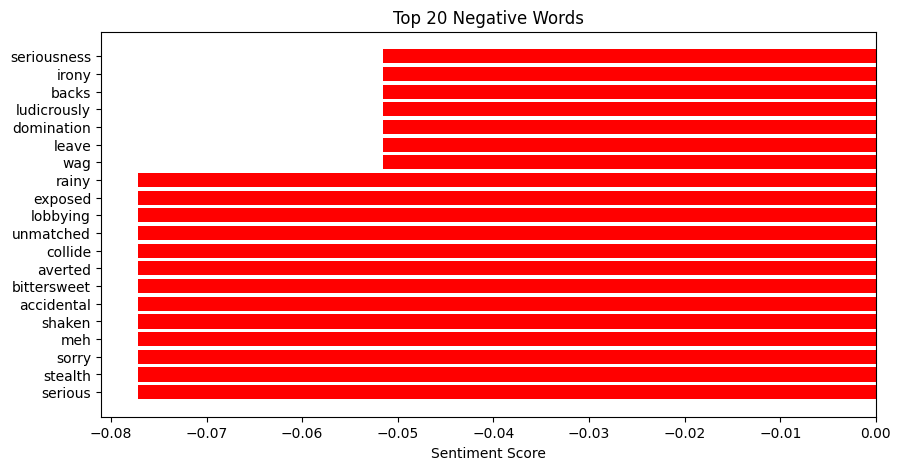

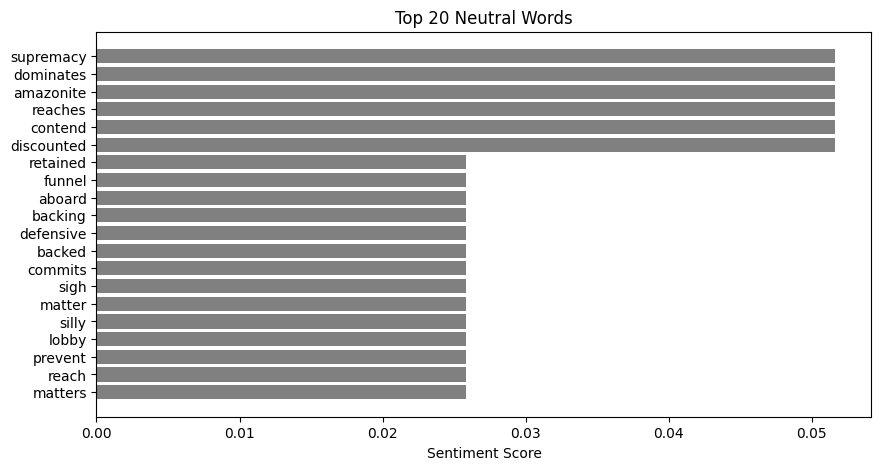

In [20]:
# Plot top sentiment words
for sentiment, words in sentiment_words.items():
    if words:
        # Sort words by their sentiment scores in descending order
        sorted_words = sorted(words.items(), key=lambda x: x[1], reverse=False)[:20]
        top_words, top_scores = zip(*sorted_words)

        # Create a bar plot for each sentiment category
        plt.figure(figsize=(10, 5))
        plt.barh(top_words, top_scores, color='green' if sentiment == 'positive' else 'red' if sentiment == 'negative' else 'gray')
        plt.title(f'Top 20 {sentiment.capitalize()} Words')
        plt.xlabel('Sentiment Score')
        plt.yticks(rotation=0)
        plt.show()

# Afterward, all the neutral words between 0 to 0.8 were removed, excluding the Named Entity Recognition with the spaCy library. However, the results were almost zero, and I did not make any progress with it.

In [21]:
amz.head()

,Date,Tweet content,Tweet language,Is a RT,Company Name,Sentiment Score,Tweet content preprocessed,Sentiment Score 2
0,2016-06-15,Try the discovery engine &amp; social network ...,en,False,Amazon,0.5106,"[try, discovery, engine, amp, social, network,...",0.5106
1,2016-06-15,"Andreas Halvorsen Buys Facebook, Amazon, Maste...",en,False,Amazon,0.1779,"[andreas, halvorsen, buys, facebook, amazon, m...",0.1779
2,2016-06-15,RT @MarketsRecap: These 3 Stocks Will Surprise...,en,True,Amazon,0.2732,"[rt, stocks, surprise, investors, earnings, se...",0.2732
3,2016-06-15,"OnePlus 3 launched at a price of Rs 27,999; av...",en,False,Amazon,0.1280,"[oneplus, launched, price, rs, available, amaz...",0.2960
4,2016-06-15,Ocado shares plummet as #Amazon Fresh launches...,en,False,Amazon,0.5423,"[ocado, shares, plummet, amazon, fresh, launch...",0.6369


In [22]:
amz.astype({'Tweet content': 'string', 'Tweet content preprocessed': 'string', 'Tweet language': 'string', 'Company Name': 'string', 'Date': 'datetime64[ns]'}).dtypes

Date                          datetime64[ns]
Tweet content                 string[python]
Tweet language                string[python]
Is a RT                                 bool
Company Name                  string[python]
Sentiment Score                      float64
Tweet content preprocessed    string[python]
Sentiment Score 2                    float64
dtype: object

In [23]:
amz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38192 entries, 0 to 38191
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        38192 non-null  object 
 1   Tweet content               38192 non-null  object 
 2   Tweet language              38192 non-null  object 
 3   Is a RT                     38192 non-null  bool   
 4   Company Name                38192 non-null  object 
 5   Sentiment Score             38192 non-null  float64
 6   Tweet content preprocessed  38192 non-null  object 
 7   Sentiment Score 2           38192 non-null  float64
dtypes: bool(1), float64(2), object(5)
memory usage: 2.1+ MB


# Instead, I simply removed the 20 most common neutral words.
- The goal is to gain a high-level overview of strong sentiments in the data

In [24]:
# List of words to be removed from analysis to experiment with sentiment change
remove_words = [
    'matters', 'reach', 'prevent', 'lobby', 'silly',
    'matter', 'sigh', 'commits', 'backed', 'defensive',
    'backing', 'aboard', 'funnel', 'retained', 'discounted',
    'contend', 'reaches', 'amazonite', 'dominates', 'supremacy'
]

In [25]:
erase = '|'.join(r"\b{}\b".format(x) for x in remove_words)

In [26]:
amz['Tweet content'] = amz['Tweet content'].str.replace(erase, '')

In [27]:
remove_words = set(remove_words)

In [28]:
F = lambda x: ' '.join(w for w in x.split() if not w in remove_words)
amz['Tweet content removed'] = amz['Tweet content'].apply(F)

In [29]:
amz.head()

,Date,Tweet content,Tweet language,Is a RT,Company Name,Sentiment Score,Tweet content preprocessed,Sentiment Score 2,Tweet content removed
0,2016-06-15,Try the discovery engine &amp; social network ...,en,False,Amazon,0.5106,"[try, discovery, engine, amp, social, network,...",0.5106,Try the discovery engine &amp; social network ...
1,2016-06-15,"Andreas Halvorsen Buys Facebook, Amazon, Maste...",en,False,Amazon,0.1779,"[andreas, halvorsen, buys, facebook, amazon, m...",0.1779,"Andreas Halvorsen Buys Facebook, Amazon, Maste..."
2,2016-06-15,RT @MarketsRecap: These 3 Stocks Will Surprise...,en,True,Amazon,0.2732,"[rt, stocks, surprise, investors, earnings, se...",0.2732,RT @MarketsRecap: These 3 Stocks Will Surprise...
3,2016-06-15,"OnePlus 3 launched at a price of Rs 27,999; av...",en,False,Amazon,0.1280,"[oneplus, launched, price, rs, available, amaz...",0.2960,"OnePlus 3 launched at a price of Rs 27,999; av..."
4,2016-06-15,Ocado shares plummet as #Amazon Fresh launches...,en,False,Amazon,0.5423,"[ocado, shares, plummet, amazon, fresh, launch...",0.6369,Ocado shares plummet as #Amazon Fresh launches...


In [30]:
amz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38192 entries, 0 to 38191
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        38192 non-null  object 
 1   Tweet content               38192 non-null  object 
 2   Tweet language              38192 non-null  object 
 3   Is a RT                     38192 non-null  bool   
 4   Company Name                38192 non-null  object 
 5   Sentiment Score             38192 non-null  float64
 6   Tweet content preprocessed  38192 non-null  object 
 7   Sentiment Score 2           38192 non-null  float64
 8   Tweet content removed       38192 non-null  object 
dtypes: bool(1), float64(2), object(6)
memory usage: 2.4+ MB


In [31]:
amz.astype({'Tweet content removed': 'string', 'Tweet content': 'string', 'Tweet content preprocessed': 'string', 'Tweet language': 'string', 'Company Name': 'string', 'Date': 'datetime64[ns]'}).dtypes

Date                          datetime64[ns]
Tweet content                 string[python]
Tweet language                string[python]
Is a RT                                 bool
Company Name                  string[python]
Sentiment Score                      float64
Tweet content preprocessed    string[python]
Sentiment Score 2                    float64
Tweet content removed         string[python]
dtype: object

In [32]:
amz['Tweet content removed'] = amz['Tweet content removed'].str.strip()

In [33]:
amz.head()

,Date,Tweet content,Tweet language,Is a RT,Company Name,Sentiment Score,Tweet content preprocessed,Sentiment Score 2,Tweet content removed
0,2016-06-15,Try the discovery engine &amp; social network ...,en,False,Amazon,0.5106,"[try, discovery, engine, amp, social, network,...",0.5106,Try the discovery engine &amp; social network ...
1,2016-06-15,"Andreas Halvorsen Buys Facebook, Amazon, Maste...",en,False,Amazon,0.1779,"[andreas, halvorsen, buys, facebook, amazon, m...",0.1779,"Andreas Halvorsen Buys Facebook, Amazon, Maste..."
2,2016-06-15,RT @MarketsRecap: These 3 Stocks Will Surprise...,en,True,Amazon,0.2732,"[rt, stocks, surprise, investors, earnings, se...",0.2732,RT @MarketsRecap: These 3 Stocks Will Surprise...
3,2016-06-15,"OnePlus 3 launched at a price of Rs 27,999; av...",en,False,Amazon,0.1280,"[oneplus, launched, price, rs, available, amaz...",0.2960,"OnePlus 3 launched at a price of Rs 27,999; av..."
4,2016-06-15,Ocado shares plummet as #Amazon Fresh launches...,en,False,Amazon,0.5423,"[ocado, shares, plummet, amazon, fresh, launch...",0.6369,Ocado shares plummet as #Amazon Fresh launches...


In [34]:
amz['Tweet content removed and preprocessed'] = amz['Tweet content removed'].apply(remove_emojis)
amz['Tweet content removed and preprocessed'] = amz['Tweet content removed and preprocessed'].apply(preprocess_tweet)
amz['Tweet content removed and preprocessed'] = amz['Tweet content removed and preprocessed'].apply(word_tokenization)

# Even after removing the 20 most common neutral words, the pattern remains unchanged.

The VADER Lexicon can also process emojis, but I opted to exclude them from the text for the reasons outlined below. Despite their absence, the underlying pattern persists, resulting in a slightly more positive score. The decision to remove emojis was made because:
- Improving the accuracy by focusing solely on textual content.
- Ensuring consistency in the data.
- Reducing the noise in analysis.
- Mitigating cultural or contextual biases.

In [35]:
# Tweets are converted from list to string before analysis
amz['Sentiment Score 3'] = amz['Tweet content removed and preprocessed'].apply(lambda tweet: sia.polarity_scores(' '.join(tweet))['compound'])

# Group by the new 'Date' column and calculate the daily average of the Sentiment Score
daily_avg = amz.groupby('Date')['Sentiment Score 3'].mean()

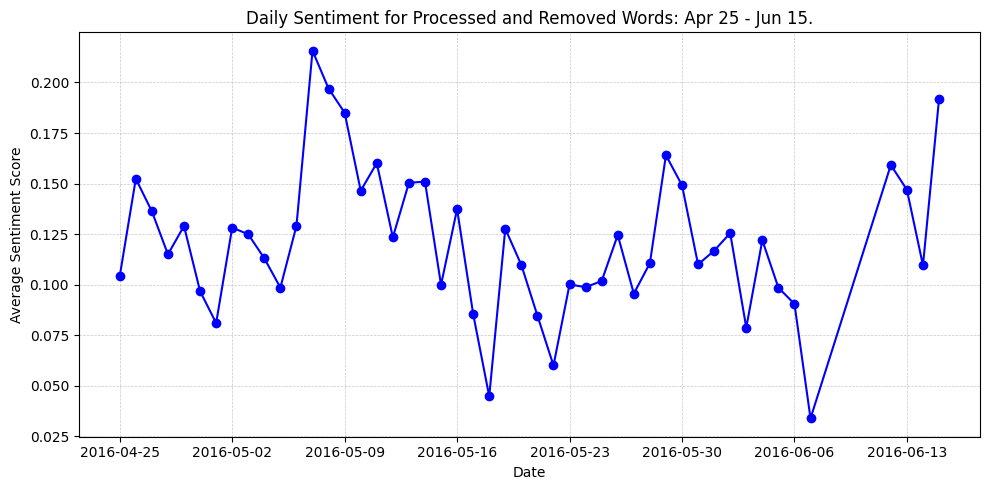

In [36]:
# Making 'daily_avg' index is of type datetime.date
daily_avg.index = pd.to_datetime(daily_avg.index).date

# Plotting with specific formatting and date handling as in the first code snippet
plt.figure(figsize=(10, 5))
plt.plot(daily_avg.index, daily_avg.values, 'bo-')  # Match marker and line style
plt.title('Daily Sentiment for Processed and Removed Words: Apr 25 - Jun 15.')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')

# Define the date format for the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set x-axis to have major ticks every 7 days and limit the display to the range
date_range = pd.date_range(start='2016-04-25', end='2016-06-15', freq='D')
plt.gca().set_xticks([date for date in date_range if date.weekday() == 0])  # Every Monday

# Enable grid for better readability of the plot
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Use tight layout to automatically adjust subplot params
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Ensure the index is of type datetime
daily_avg.index = pd.to_datetime(daily_avg.index)

# Creating the plot with Plotly Express
fig = px.line(
    daily_avg,  # Assuming 'daily_avg' is a DataFrame with a datetime index and a column named 'value'
    x=daily_avg.index,
    y=daily_avg.values,
    title='Daily Sentiment for Processed and Removed Words: Apr 25 - Jun 15',
    labels={'x': 'Date', 'y': 'Average Sentiment Score'},
    markers=True,  # Adds markers to the line plot
    line_shape='linear'  # Ensures the line is linear between points
)

# Customizing x-axis date format and interval
fig.update_xaxes(
    dtick="M1",  # Monthly ticks; use 'D1' for daily ticks or 'W1' for weekly ticks on Mondays
    tickformat='%Y-%m-%d'
)

# Show the plot
fig.show()

# Amazon Stock Prices for Further Analysis

In [38]:
# Ticker symbol for Amazon
ticker_symbol = 'AMZN'

# Selecting the date range of tweets and their end date.
start_date = '2016-04-25'
end_date = '2016-06-16'

# Fetch the data from Yahoo Finance
apple_stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


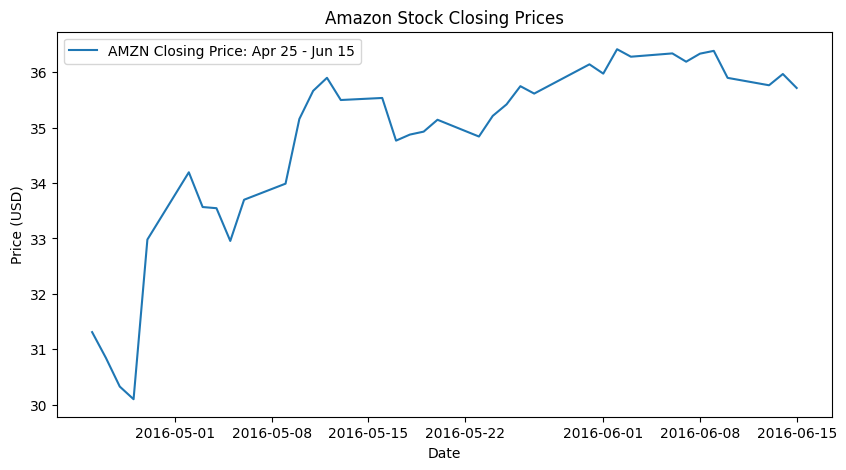

In [39]:
# Plot the closing prices
plt.figure(figsize=(10, 5))
plt.plot(apple_stock_data['Close'], label='AMZN Closing Price: Apr 25 - Jun 15')
plt.title('Amazon Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [40]:
# Plot the closing prices with Plotly Express
fig = px.line(apple_stock_data, x=apple_stock_data.index, y='Close',
              title='Amazon Stock Closing Prices(Interactive)', labels={'x': 'Date', 'Close': 'Price (USD)'})
fig.update_traces(mode='lines', line=dict(width=2), name='AMZN Closing Price')
fig.update_layout(legend_title_text='Legend')
fig.show()